# Capacity allocation

## 0. Load libraries

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behaviour, get_revenue_behaviour_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from typing import Any, List, Mapping, Tuple, Union
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [4]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [5]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
RU2                     4
RU3                    10
RU1                     6
RU4                     5
Total                  25


In [6]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  25


/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


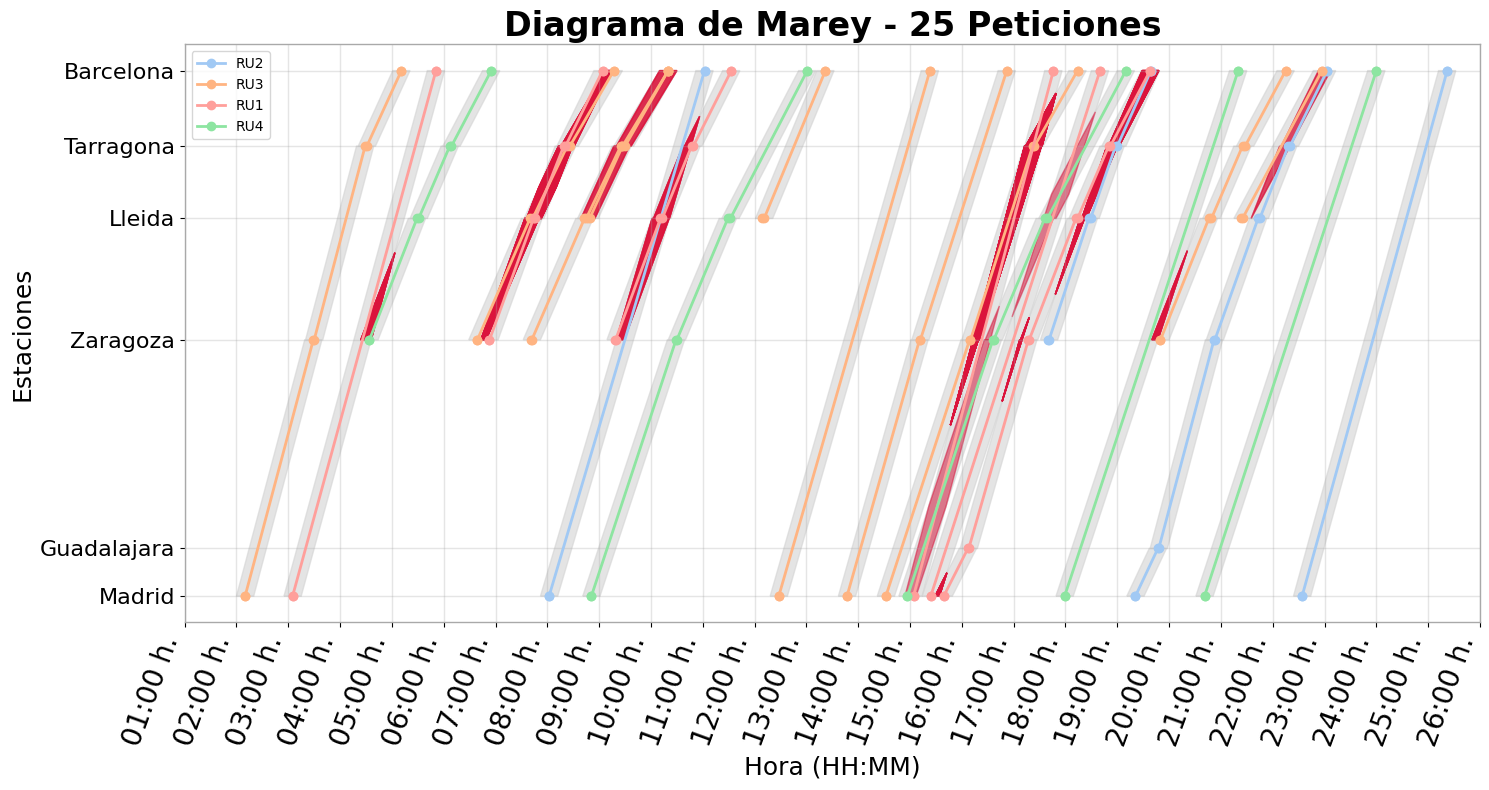

In [7]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - 25 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [20]:
from src.timetabling_problem import MPTT

mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

In [29]:
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from mealpy.physics_based import SA

mp_algos = {"Genetic Algorithm": GA.BaseGA,
            "Particle Swarm Optimization": PSO.OriginalPSO,
            "Simulated Annealing": SA.OriginalSA,
            "Differential Evolution": DE.OriginalDE,
            "Ant Colony Optimization Continuous (ACOR)": ACOR.OriginalACOR,
            "Covariance Matrix Adaptation Evolution Strategy": ES.CMA_ES,
            "Artificial Bee Colony": ABC.OriginalABC,
            "Grey Wolf Optimizer": GWO.OriginalGWO,
            "Whale Optimization Algorithm": WOA.OriginalWOA,
            "Hybrid Grey Wolf - Whale Optimization Algorithm": GWO.GWO_WOA}

In [30]:
from mealpy import IntegerVar

runs = 1
epochs = 100
pop_size = 50

# 0. Problem formulation
lb, ub = zip(*mptt.boundaries.real)

problem = {"obj_func": mptt.objective_function,
           "bounds": IntegerVar(lb=lb,
                              ub=ub),
           "minmax": "max",
           "save_population": True}

# 1. Iter algorithms
df_history = pd.DataFrame()
df_population = pd.DataFrame()

for algo_name, algo in mp_algos.items():
    print(f"Running {algo_name}")
    for r in range(1, runs+1):
        print("\tRun: ", r)
        
        # Run algorithm
        if algo_name == "Simulated Annealing":
            optimizer = algo(epoch=epochs*pop_size)
            optimizer.solve(problem)
        else:
            optimizer = algo(epoch=epochs, pop_size=pop_size)
            optimizer.solve(problem)
            
        # Build run history dataframe
        columns = ['Algo', 'Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real', 
                   'Diversity', 'Exploitation', 'Exploration']
        run_history = pd.DataFrame(columns=columns)
        
        # Save optimizer history to dataframe
        for i, data in enumerate(optimizer.history.list_global_best):
            mptt.update_schedule(data.solution)
            run_history.loc[i] = [algo_name,
                                  i, 
                                  data.target.fitness,
                                  optimizer.history.list_epoch_time[i],
                                  mptt.get_heuristic_schedule(),
                                  data.solution,
                                  optimizer.history.list_diversity[i],
                                  optimizer.history.list_exploitation[i],
                                  optimizer.history.list_exploration[i]]
    
        run_history.insert(0, "Run", r)
        df_history = pd.concat([df_history, run_history], axis=0)
        
        # Population dataframe
        if algo_name == "Simulated Annealing":
            continue
        
        population_colums = [f'real_{i}' for i in range(pop_size)] + [f'discrete_{i}' for i in range(pop_size)]
        population_colums.insert(0, 'Iteration')
        run_population = pd.DataFrame(columns=population_colums)
        
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_row = [i]
            real = []
            discrete = [] 
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real.append(individual.solution)
                discrete.append(mptt.get_heuristic_schedule())
            
            population_row = [i, *real, *discrete]
            run_population.loc[len(run_population)] = population_row
        
        run_population.insert(0, "Run", r)
        df_population = pd.concat([df_population, run_population], axis=0)    

2024/11/22 01:57:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Genetic Algorithm
	Run:  1


2024/11/22 01:57:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1679.8904519247053, Global best: 1679.8904519247053, Runtime: 0.25899 seconds
2024/11/22 01:57:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1943.346377649125, Global best: 1943.346377649125, Runtime: 0.25266 seconds
2024/11/22 01:57:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2052.3777450142616, Global best: 2052.3777450142616, Runtime: 0.24790 seconds
2024/11/22 01:57:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2254.925861949425, Global best: 2254.925861949425, Runtime: 0.24508 seconds
2024/11/22 01:57:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2418.213201970074, Global best: 2418.213201970074, Runtime: 0.24283 seconds
2024/11/22 01:57:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

Running Particle Swarm Optimization
	Run:  1


2024/11/22 01:58:39 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 1901.9453032761553, Global best: 1901.9453032761553, Runtime: 0.24620 seconds
2024/11/22 01:58:39 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2203.31726319158, Global best: 2203.31726319158, Runtime: 0.24572 seconds
2024/11/22 01:58:39 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2203.31726319158, Global best: 2203.31726319158, Runtime: 0.24605 seconds
2024/11/22 01:58:40 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2203.31726319158, Global best: 2203.31726319158, Runtime: 0.24323 seconds
2024/11/22 01:58:40 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2412.2664041120956, Global best: 2412.2664041120956, Runtime: 0.24710 seconds
2024/11/22 01:58:40 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, Curren

Running Simulated Annealing
	Run:  1


2024/11/22 02:01:15 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 38, Current best: 1145.5723634584824, Global best: 1145.5723634584824, Runtime: 0.00467 seconds
2024/11/22 02:01:15 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 39, Current best: 1145.5723634584824, Global best: 1145.5723634584824, Runtime: 0.00451 seconds
2024/11/22 02:01:15 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 40, Current best: 1145.5723634584824, Global best: 1145.5723634584824, Runtime: 0.00452 seconds
2024/11/22 02:01:15 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 41, Current best: 1145.5723634584824, Global best: 1145.5723634584824, Runtime: 0.00453 seconds
2024/11/22 02:01:15 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 42, Current best: 1145.5723635382667, Global best: 1145.5723635382667, Runtime: 0.00454 seconds
2024/11/22 02:01:15 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

Running Differential Evolution
	Run:  1


2024/11/22 02:53:02 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 1584.7663146826903, Global best: 1584.7663146826903, Runtime: 0.22656 seconds
2024/11/22 03:10:14 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 1584.7663146826903, Global best: 1584.7663146826903, Runtime: 0.54647 seconds
2024/11/22 03:10:14 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 1795.219210788233, Global best: 1795.219210788233, Runtime: 0.22566 seconds
2024/11/22 03:10:14 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 1795.219210788233, Global best: 1795.219210788233, Runtime: 0.22336 seconds
2024/11/22 03:10:15 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2166.512129170391, Global best: 2166.512129170391, Runtime: 0.22557 seconds
2024/11/22 03:10:15 PM, INFO, mealpy.evolutionary_based.DE.Origina

Running Ant Colony Optimization Continuous (ACOR)
	Run:  1


2024/11/22 03:20:50 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 1713.6363717173244, Global best: 1713.6363717173244, Runtime: 0.15024 seconds
2024/11/22 03:20:50 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 1783.0171960721182, Global best: 1783.0171960721182, Runtime: 0.15056 seconds
2024/11/22 03:20:50 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2358.465710152549, Global best: 2358.465710152549, Runtime: 0.14063 seconds
2024/11/22 03:20:51 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2358.465710152549, Global best: 2358.465710152549, Runtime: 0.14619 seconds
2024/11/22 03:20:51 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2358.465710152549, Global best: 2358.465710152549, Runtime: 0.14695 seconds
2024/11/22 03:20:51 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P

Running Covariance Matrix Adaptation Evolution Strategy
	Run:  1


2024/11/22 03:21:26 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 1154.597916832014, Global best: 1565.6403365090484, Runtime: 0.41330 seconds
2024/11/22 03:21:26 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 947.2422880362832, Global best: 1565.6403365090484, Runtime: 0.49668 seconds
2024/11/22 03:21:27 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 1068.6177084504668, Global best: 1565.6403365090484, Runtime: 0.45077 seconds
2024/11/22 03:21:27 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 1061.695666085459, Global best: 1565.6403365090484, Runtime: 0.53157 seconds
2024/11/22 03:21:28 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 1145.7692867080027, Global best: 1565.6403365090484, Runtime: 0.45132 seconds
2024/11/22 03:21:28 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, E

Running Artificial Bee Colony
	Run:  1


2024/11/22 03:22:40 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 1702.8056208095513, Global best: 1702.8056208095513, Runtime: 0.48478 seconds
2024/11/22 03:22:41 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 1997.686100002084, Global best: 1997.686100002084, Runtime: 0.48223 seconds
2024/11/22 03:22:41 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2100.7511291058668, Global best: 2100.7511291058668, Runtime: 0.48741 seconds
2024/11/22 03:22:42 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2100.7511291058668, Global best: 2100.7511291058668, Runtime: 0.48672 seconds
2024/11/22 03:22:42 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2332.4143628065162, Global best: 2332.4143628065162, Runtime: 0.48323 seconds
2024/11/22 03:22:43 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch:

Running Grey Wolf Optimizer
	Run:  1


2024/11/22 03:23:51 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 1873.024428933907, Global best: 1873.024428933907, Runtime: 0.23999 seconds
2024/11/22 03:23:51 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2392.929537231302, Global best: 2392.929537231302, Runtime: 0.24706 seconds
2024/11/22 03:23:51 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2392.929537231302, Global best: 2392.929537231302, Runtime: 0.24245 seconds
2024/11/22 03:23:52 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2392.929537231302, Global best: 2392.929537231302, Runtime: 0.24075 seconds
2024/11/22 03:23:52 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2392.929537231302, Global best: 2392.929537231302, Runtime: 0.24460 seconds
2024/11/22 03:23:52 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, Curr

Running Whale Optimization Algorithm
	Run:  1


2024/11/22 03:24:36 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 2582.291394265095, Global best: 2582.291394265095, Runtime: 0.24625 seconds
2024/11/22 03:24:37 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 2582.291394265095, Global best: 2582.291394265095, Runtime: 0.24376 seconds
2024/11/22 03:24:37 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 2582.291394265095, Global best: 2582.291394265095, Runtime: 0.24600 seconds
2024/11/22 03:24:37 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 2582.291394265095, Global best: 2582.291394265095, Runtime: 0.24526 seconds
2024/11/22 03:24:37 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 2582.291394265095, Global best: 2582.291394265095, Runtime: 0.24506 seconds
2024/11/22 03:24:38 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Curr

Running Hybrid Grey Wolf - Whale Optimization Algorithm
	Run:  1


2024/11/22 03:25:22 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2263.3337754651934, Global best: 2263.3337754651934, Runtime: 0.24172 seconds
2024/11/22 03:25:22 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2263.3337754651934, Global best: 2263.3337754651934, Runtime: 0.25110 seconds
2024/11/22 03:25:23 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2263.3337754651934, Global best: 2263.3337754651934, Runtime: 0.24290 seconds
2024/11/22 03:25:23 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2263.3337754651934, Global best: 2263.3337754651934, Runtime: 0.24594 seconds
2024/11/22 03:25:23 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2371.8937895712074, Global best: 2371.8937895712074, Runtime: 0.24124 seconds
2024/11/22 03:25:23 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2371

In [ ]:
reports_path = Path('../reports/')

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)



for s_idx in range(89, 101): 
    times_sol = np.array(optimizer.history.list_global_best[s_idx].solution, dtype=int)
    
    mptt.update_schedule(mptt.best_solution.real)
    
    solution = Solution(real=times_sol, discrete=mptt.get_heuristic_schedule())

    services = sm.update_supply(path=generator_save_path,
                                solution=solution)
    
    sm.update_schedule(solution=solution)
    
    filtered_services = {}
    for i, service in enumerate(sm.updated_schedule):
        if mptt.best_solution.discrete[i]:
            filtered_services[service] = sm.updated_schedule[service]
    
    #plotter = TrainSchedulePlotter(filtered_services, line)
    #plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))
    
    tt_file_name = f'{supply_config_path.stem}_mptt_ga'
    print(supply_save_path, tt_file_name)
    SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)
    
    # Copy previous file in reports
    shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'mealpy/{tt_file_name}_25_mptt_ga.yml')
    
    supply_config_file = Path(f'{supply_save_path}{tt_file_name}_25_mptt_ga.yml')
    
    final_supply = Supply.from_yaml("../reports/mealpy/supply_config_mptt_ga_25_mptt_ga.yml")
    
    plot_marey_chart(requested_supply=final_supply,
                     colors_by_tsp=True, 
                     main_title=f"Diagrama de Marey - 25 Peticiones {s_idx}",
                     plot_security_gaps=True,
                     security_gap=10,
                     save_path=Path('../reports/gsa/marey_chart_requests_25.pdf'))

## 2. Results analysis

In [32]:
reports_path = Path('../reports/')

# Save df_gcc and df_gpp
df_history.to_csv(reports_path / 'mealpy/df_history.csv', index=False)

In [33]:
df_population.to_csv(reports_path / 'mealpy/df_population.csv', index=False)

In [34]:
# Define new revenue maximization object for results analysis
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

In [35]:
df_history

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,1679.890452,0.258992,"[False, False, False, True, True, False, True,...","[1063.0, 1103.0, 1146.0, 878.0, 967.0, 1044.0,...",2.874386,0.000000,100.000000
1,1,Genetic Algorithm,1,1943.346378,0.252662,"[False, True, False, True, True, False, True, ...","[1063.0, 1103.0, 1146.0, 869.0, 967.0, 1050.0,...",2.640351,8.142090,91.857910
2,1,Genetic Algorithm,2,2052.377745,0.247901,"[False, True, False, True, True, True, True, F...","[1063.0, 1103.0, 1145.0, 863.0, 967.0, 1047.0,...",2.402105,16.430664,83.569336
3,1,Genetic Algorithm,3,2254.925862,0.245082,"[False, True, False, True, True, True, True, F...","[1063.0, 1103.0, 1147.0, 863.0, 963.0, 1047.0,...",2.193684,23.681641,76.318359
4,1,Genetic Algorithm,4,2418.213202,0.242831,"[False, True, False, True, True, True, True, F...","[1063.0, 1103.0, 1145.0, 863.0, 963.0, 1044.0,...",1.988772,30.810547,69.189453
...,...,...,...,...,...,...,...,...,...,...
95,1,Hybrid Grey Wolf - Whale Optimization Algorithm,95,2876.799262,0.247107,"[False, True, False, True, True, True, True, F...","[1059.7980577229284, 1106.9999, 1147.9999, 861...",4.678112,18.126911,81.873089
96,1,Hybrid Grey Wolf - Whale Optimization Algorithm,96,2876.799262,0.246522,"[False, True, False, True, True, True, True, F...","[1059.7980577229284, 1106.9999, 1147.9999, 861...",4.678112,18.126911,81.873089
97,1,Hybrid Grey Wolf - Whale Optimization Algorithm,97,2876.799262,0.248703,"[False, True, False, True, True, True, True, F...","[1059.7980577229284, 1106.9999, 1147.9999, 861...",4.678112,18.126911,81.873089
98,1,Hybrid Grey Wolf - Whale Optimization Algorithm,98,2876.799262,0.245322,"[False, True, False, True, True, True, True, F...","[1059.7980577229284, 1106.9999, 1147.9999, 861...",4.678112,18.126911,81.873089


In [36]:
df_population

,Run,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,real_7,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,0,"[1062.0, 1103.0, 1143.0, 863.0, 963.0, 1047.0,...","[1063.0, 1105.0, 1143.0, 868.0, 961.0, 1051.0,...","[1051.0, 1101.0, 1142.0, 867.0, 959.0, 1051.0,...","[1054.0, 1099.0, 1145.0, 863.0, 967.0, 1043.0,...","[1054.0, 1101.0, 1147.0, 869.0, 963.0, 1043.0,...","[1064.0, 1103.0, 1145.0, 877.0, 963.0, 1047.0,...","[1060.0, 1105.0, 1146.0, 878.0, 961.0, 1044.0,...","[1063.0, 1103.0, 1143.0, 863.0, 967.0, 1047.0,...",...,"[False, False, False, True, True, True, True, ...","[False, True, False, True, True, False, True, ...","[False, False, False, True, True, False, True,...","[False, True, False, True, True, True, True, F...","[False, True, False, True, True, True, True, F...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, True, True, F...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, True, True, F...","[False, True, False, True, True, False, True, ..."
1,1,1,"[1063.0, 1101.0, 1143.0, 863.0, 967.0, 1050.0,...","[1054.0, 1101.0, 1145.0, 863.0, 963.0, 1043.0,...","[1063.0, 1103.0, 1146.0, 872.0, 967.0, 1044.0,...","[1063.0, 1103.0, 1146.0, 869.0, 967.0, 1050.0,...","[1061.0, 1105.0, 1143.0, 878.0, 961.0, 1047.0,...","[1063.0, 1105.0, 1147.0, 869.0, 961.0, 1047.0,...","[1063.0, 1103.0, 1146.0, 878.0, 967.0, 1044.0,...","[1063.0, 1103.0, 1146.0, 869.0, 967.0, 1050.0,...",...,"[False, False, False, True, True, True, True, ...","[False, False, False, True, True, False, True,...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, True, True, F...","[False, True, False, True, True, True, True, F...","[False, True, False, True, True, True, True, F...","[False, False, False, True, True, True, True, ...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, True, True, F...","[False, True, False, True, True, False, True, ..."
2,1,2,"[1063.0, 1105.0, 1147.0, 863.0, 963.0, 1043.0,...","[1062.0, 1103.0, 1146.0, 869.0, 967.0, 1047.0,...","[1063.0, 1105.0, 1147.0, 869.0, 968.0, 1043.0,...","[1063.0, 1105.0, 1147.0, 869.0, 961.0, 1047.0,...","[1063.0, 1099.0, 1147.0, 878.0, 967.0, 1043.0,...","[1060.0, 1101.0, 1145.0, 863.0, 961.0, 1044.0,...","[1063.0, 1103.0, 1146.0, 863.0, 963.0, 1044.0,...","[1062.0, 1102.0, 1146.0, 878.0, 968.0, 1047.0,...",...,"[False, True, False, True, True, True, True, F...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, True, True, F...","[False, True, False, True, True, True, True, F...","[False, True, False, True, True, True, True, F...","[False, True, False, True, True, True, True, F...","[False, False, False, True, True, True, True, ...","[False, False, False, True, True, True, True, ...","[False, False, False, True, True, True, True, ..."
3,1,3,"[1060.0, 1101.0, 1146.0, 863.0, 963.0, 1044.0,...","[1063.0, 1103.0, 1145.0, 863.0, 961.0, 1044.0,...","[1060.0, 1101.0, 1145.0, 869.0, 967.0, 1051.0,...","[1061.0, 1103.0, 1146.0, 863.0, 961.0, 1044.0,...","[1063.0, 1103.0, 1146.0, 869.0, 967.0, 1051.0,...","[1061.0, 1103.0, 1145.0, 863.0, 967.0, 1047.0,...","[1063.0, 1103.0, 1146.0, 869.0, 963.0, 1051.0,...","[1061.0, 1103.0, 1146.0, 863.0, 967.0, 1044.0,...",...,"[False, True, False, True, True, False, True, ...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, False, True, ...","[False, True, False, True, True, False, True, ..."
4,1,4,"[1061.0, 1101.

In [37]:
# Create dataframe with fitness values for each individual of the population
df_pop = df_population.copy()

df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

def fitness_from_real(x: np.array) -> float:
    solution_gsa = Solution(real=x, discrete=np.array([]))
    fitness, _ = sm.get_fitness_gsa(timetable=solution_gsa)
    return fitness

df_pop.loc[:, df_pop.columns.str.contains('real_')] = df_pop.loc[:, df_pop.columns.str.contains('real_')].map(fitness_from_real)
df_pop

KeyboardInterrupt: 

In [ ]:
# Save df_pop
df_pop.to_csv(reports_path / 'mealpy/df_pop_fit.csv', index=False)

In [53]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    chaotic = row[1]['chaotic_constant']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Chaotic': chaotic, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

""


In [54]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 9, 19, 29, 39, 49])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Chaotic',
             title="Diagrama de caja disperso de la evalución de individuos",
             x_label="Iteraciones",
             y_label="Fitness (Beneficio)",
             save_path=Path('../reports/gsa/scattered_boxplot_25.pdf'))

KeyError: 'Iteration'

In [55]:
df_gcc

,Run,Iteration,Fitness,ExecutionTime,Discrete,Real
0,1,0,2490.609101,0.245138,"[False, True, False, True, True, True, True, F...","[1066.0, 1113.0, 1140.0, 872.0, 970.0, 1048.0,..."
1,1,1,2735.944798,0.232498,"[False, True, False, True, True, False, True, ...","[1066.0, 1113.0, 1146.0, 871.0, 974.0, 1048.0,..."
2,1,2,2735.944798,0.241787,"[False, True, False, True, True, False, True, ...","[1066.0, 1113.0, 1146.0, 871.0, 974.0, 1048.0,..."
3,1,3,3118.945689,0.235366,"[False, True, False, True, True, True, True, F...","[1051.0, 1113.0, 1148.0, 872.0, 970.0, 1048.0,..."
4,1,4,3230.402017,0.272952,"[False, True, False, True, True, True, True, F...","[1066.0, 1113.0, 1148.0, 871.0, 970.0, 1052.0,..."
...,...,...,...,...,...,...
95,5,95,4378.600190,0.248237,"[False, True, False, True, True, True, True, F...","[1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,..."
96,5,96,4378.600190,0.249454,"[False, True, False, True, True, True, True, F...","[1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,..."
97,5,97,4378.600190,0.260521,"[False, True, False, True, True, True, True, F...","[1068.0, 1113.0, 1145.0, 871.0, 970.0, 1044.0,..."
98,5,98,4383.045238,0.251938,"[False, True, False, True, True, True, True, F...","[1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,..."


In [43]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Algorithm', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('Algo')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
        execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
        row_data =  [algo_group[0], run, revenue, execution_time, 
                     scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

,Algorithm,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU2,RU3,RU4,RU1
4,Genetic Algorithm,1,3530.300452,0.251609,16,36.000000,103.000000,50.0 %,80.0 %,33.33 %,80.0 %
0,Ant Colony Optimization Continuous (ACOR),1,3343.919659,0.143960,17,123.494585,114.635936,50.0 %,90.0 %,33.33 %,80.0 %
1,Artificial Bee Colony,1,3303.694326,0.492575,17,105.372201,128.380213,50.0 %,90.0 %,33.33 %,80.0 %
5,Grey Wolf Optimizer,1,3048.078393,0.251398,16,114.515867,149.678967,50.0 %,80.0 %,33.33 %,80.0 %
3,Differential Evolution,1,2988.530962,0.233097,17,87.005024,138.245539,50.0 %,90.0 %,33.33 %,80.0 %
7,Particle Swarm Optimization,1,2949.120267,0.249991,17,99.318292,140.091211,50.0 %,90.0 %,33.33 %,80.0 %
6,Hybrid Grey Wolf - Whale Optimization Algorithm,1,2876.799262,0.249823,17,177.284985,177.924630,50.0 %,80.0 %,50.0 %,80.0 %
9,Whale Optimization Algorithm,1,2875.354479,0.248691,15,93.002740,183.218080,50.0 %,70.0 %,33.33 %,80.0 %
8,Simulated Annealing,1,2101.892542,0.005064,16,86.757071,138.975954,50.0 %,70.0 %,33.33 %,100.0 %
2,Covariance Matrix Adaptation Evolution Strategy,1,1565.640337,0.472580,17,99.000000,180.000000,50.0 %,80.0 %,33.33 %,100.0 %


In [57]:
summary_df.to_latex()

'\\begin{tabular}{lrrrrrrllll}\n\\toprule\n & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU2 & RU3 \\\\\n\\midrule\n3 & 4 & 4426.264895 & 0.253619 & 18 & 22.000000 & 16.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n2 & 3 & 4424.627215 & 0.252669 & 18 & 20.000000 & 16.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n0 & 1 & 4423.893212 & 0.242613 & 18 & 23.000000 & 21.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n1 & 2 & 4412.845974 & 0.247379 & 18 & 19.000000 & 20.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n4 & 5 & 4383.045238 & 0.249751 & 18 & 23.000000 & 20.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n\\bottomrule\n\\end{tabular}\n'

In [46]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Ant Colony Optimization Continuous (ACOR) status:
	Total execution time: 0.144 s.
	Execution Time (by run) - Mean: 0.144 s. - Std: nan s.
	Revenue - Mean: 3343.9197 - Std: nan
	Scheduled Trains - Mean: 17.0 - Std: nan
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Artificial Bee Colony status:
	Total execution time: 0.4926 s.
	Execution Time (by run) - Mean: 0.4926 s. - Std: nan s.
	Revenue - Mean: 3303.6943 - Std: nan
	Scheduled Trains - Mean: 17.0 - Std: nan
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Covariance Matrix Adaptation Evolution Strategy status:
	Total execution time: 0.4726 s.
	Execution Time (by run) - Mean: 0.4726 s. - Std: nan s.
	Revenue - Mean: 1565.6403 - Std: nan
	Scheduled Trains - Mean: 17.0 - Std: nan
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Differential Evolution status:
	Total execution time: 0.2331 s.
	Execution Time (by run)

In [61]:
df_train_nc = df_gcc
_ = get_gsa_global_status(df_train_nc)

Global GSA status:
	Total execution time: 1.246 s.
	Execution Time (by run) - Mean: 0.2492 s. - Std: 0.0044 s.
	Revenue - Mean: 4414.1353 - Std: 18.1706
	Scheduled Trains - Mean: 18.0 - Std: 0.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible


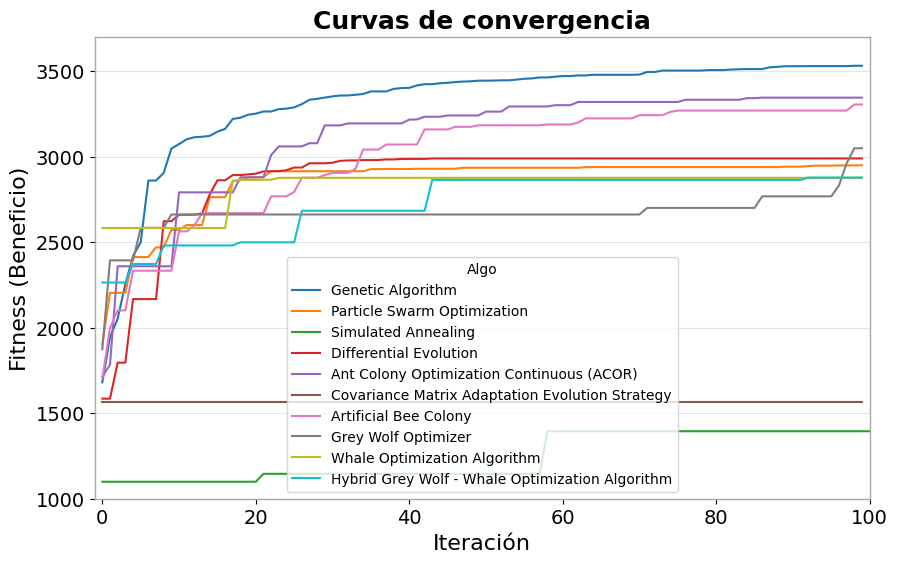

In [56]:
# GSA Convergence plot
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Curvas de convergencia",
              x_label="Iteración",
              y_label="Fitness (Beneficio)",
              x_limit=(-1, 100),
              y_limit=(1000,3700),
              save_path=Path('../reports/mealpy/mealpy_convergence.pdf'))

In [44]:
from scipy import stats

fitness_sCGSA = summary_df['Revenue'].values
fitness_GSA = summary_df_nc['Revenue'].values

fitness_sCGSA, fitness_GSA

(array([2722.30486112, 2253.2369699 , 2239.2765139 , 2107.4293723 ,
        2089.71226206]),
 array([2722.30486112, 2253.2369699 , 2239.2765139 , 2107.4293723 ,
        2089.71226206]))

In [45]:
stat, p_value = stats.wilcoxon(fitness_sCGSA, fitness_GSA)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [23]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

sm.update_schedule(solution=gsa_solution[1][0])

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/gsa_results/ supply_config_gsa


In [24]:
final_supply = Supply.from_yaml(supply_config_file)

{'1_2024-06-25-14.32': {'Madrid': [869.0, 869.0], 'Zaragoza': [966.0, 971.0], 'Tarragona': [1043.0, 1046.0], 'Barcelona': [1096.0, 1096.0]}, '3_2024-06-25-13.47': {'Madrid': [827.0, 827.0], 'Zaragoza': [911.0, 912.0], 'Barcelona': [1012.0, 1012.0]}, '4_2024-06-25-22.34': {'Madrid': [1354.0, 1354.0], 'Barcelona': [1522.0, 1522.0]}, '5_2024-06-25-12.09': {'Lleida': [732.0, 732.0], 'Barcelona': [803.0, 803.0]}, '6_2024-06-25-2.10': {'Madrid': [126.0, 126.0], 'Zaragoza': [205.0, 211.0], 'Tarragona': [270.0, 277.0], 'Barcelona': [317.0, 317.0]}, '8_2024-06-25-8.51': {'Madrid': [530.0, 530.0], 'Zaragoza': [628.0, 631.0], 'Lleida': [690.0, 693.0], 'Barcelona': [782.0, 782.0]}, '10_2024-06-25-12.28': {'Madrid': [748.0, 748.0], 'Barcelona': [923.0, 923.0]}, '12_2024-06-25-6.38': {'Zaragoza': [399.0, 399.0], 'Lleida': [460.0, 464.0], 'Tarragona': [504.0, 507.0], 'Barcelona': [558.0, 558.0]}, '13_2024-06-25-15.39': {'Madrid': [939.0, 939.0], 'Guadalajara': [967.0, 968.0], 'Zaragoza': [1037.0, 104

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


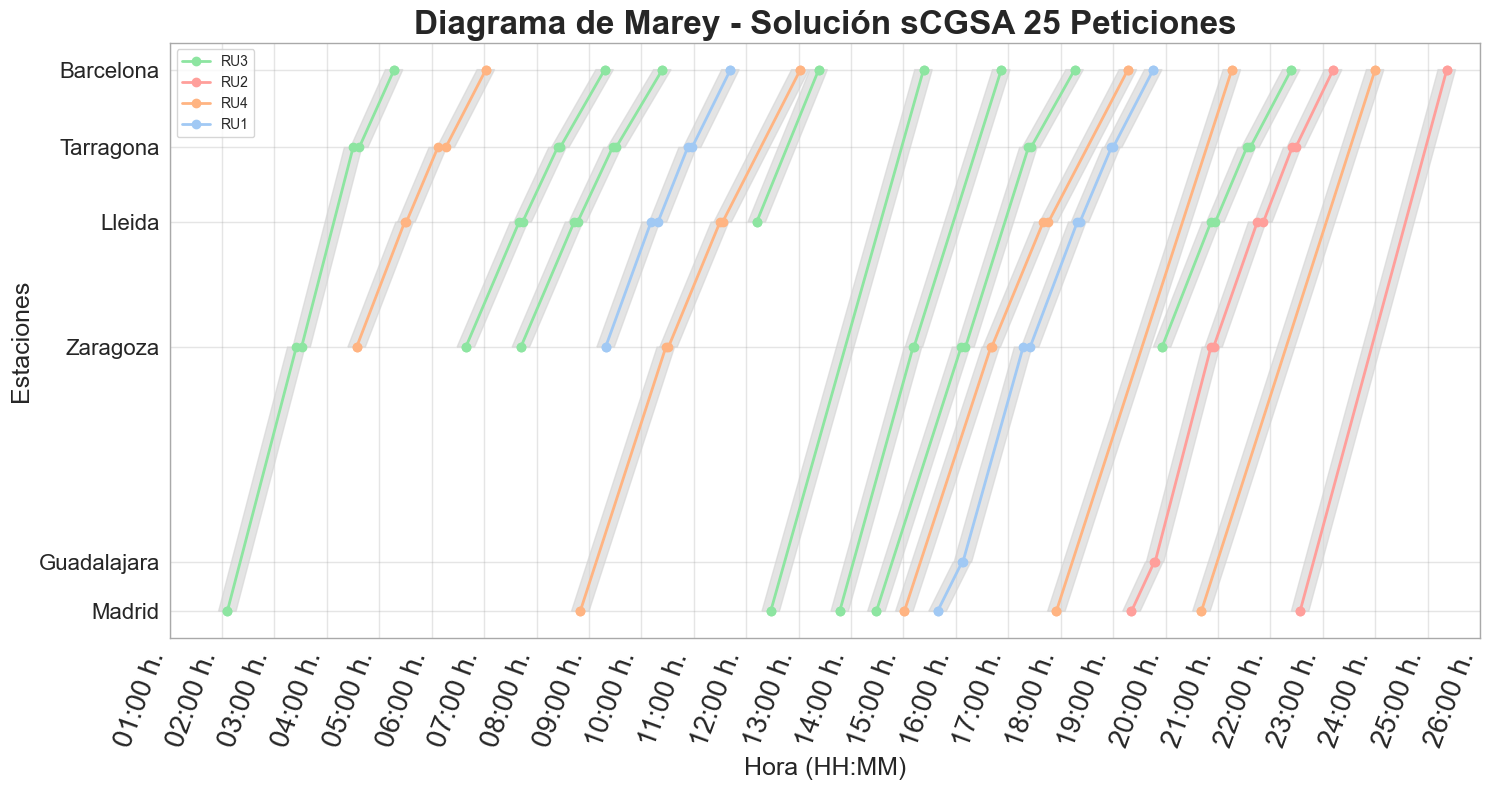

In [25]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - Solución sCGSA 25 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_sol_25.pdf'))

In [29]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25.yml')

PosixPath('../reports/gsa/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat